<a href="https://www.kaggle.com/code/averma111/pytorch-hubmap-cnn?scriptVersionId=132301374" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import json
from torch.utils.data import Dataset, DataLoader
from torchmetrics import AveragePrecision
import torch
import torchvision
from torchvision.transforms import transforms
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.nn.functional as F
import time
import base64
import typing as t
import zlib

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
%%capture
!mkdir /kaggle/working/packages
!cp -r /kaggle/input/pycocotools/* /kaggle/working/packages
os.chdir("/kaggle/working/packages/pycocotools-2.0.6/")
!python setup.py install
!pip install . --no-index --find-links /kaggle/working/packages/
os.chdir("/kaggle/working")
from pycocotools import _mask as coco_mask

In [3]:
class Config:
    
    batch_size= 64
    n_epochs = 10
    learning_rate = 0.001
    
    
    
config = Config()

In [4]:
class Acquisition:
    
    def get_datframe(self,path):
        return pd.read_csv(path)
    
    def get_json_dataframe(self, json_file):
        data = []
        with open(json_file, 'r') as file:
            for line in file:
                item = json.loads(line)
                data.append(item)
        
        json_df = pd.DataFrame(data)
        return json_df
    
        
        
acq = Acquisition()      

In [5]:
title=acq.get_datframe(path='/kaggle/input/hubmap-hacking-the-human-vasculature/tile_meta.csv')
title.head()

,id,source_wsi,dataset,i,j
0,0006ff2aa7cd,2,2,16896,16420
1,000e79e206b7,6,3,10240,29184
2,00168d1b7522,2,2,14848,14884
3,00176a88fdb0,7,3,14848,25088
4,0033bbc76b6b,1,1,10240,43008


In [6]:
wsi = acq.get_datframe(path='/kaggle/input/hubmap-hacking-the-human-vasculature/wsi_meta.csv')
wsi.head()

,source_wsi,age,sex,race,height,weight,bmi
0,1,58,F,W,160.0,59.0,23.0
1,2,56,F,W,175.2,139.6,45.5
2,3,73,F,W,162.3,87.5,33.2
3,4,53,M,B,166.0,73.0,26.5


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
polygons_df = acq.get_json_dataframe('/kaggle/input/hubmap-hacking-the-human-vasculature/polygons.jsonl')
polygons_df.head()

,id,annotations
0,0006ff2aa7cd,"[{'type': 'glomerulus', 'coordinates': [[[167,..."
1,00168d1b7522,"[{'type': 'glomerulus', 'coordinates': [[[511,..."
2,0033bbc76b6b,"[{'type': 'blood_vessel', 'coordinates': [[[16..."
3,003504460b3a,"[{'type': 'blood_vessel', 'coordinates': [[[40..."
4,004daf1cbe75,"[{'type': 'blood_vessel', 'coordinates': [[[14..."


In [9]:
class ImageHuBMAPDataset(Dataset):
    
    def __init__(self, image_dir, labels_file, transform=None):
        
        with open(labels_file, 'r') as json_file:
            self.json_labels = [json.loads(line) for line in json_file]
            
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.json_labels)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, f"{self.json_labels[idx]['id']}.tif")
        image = Image.open(image_path)

        mask = np.zeros((512, 512), dtype=np.float32)

        for annot in self.json_labels[idx]['annotations']:
            cords = annot['coordinates']
            if annot['type'] == "blood_vessel":
                for cd in cords:
                    rr, cc = np.array([i[1] for i in cd]), np.asarray([i[0] for i in cd])
                    mask[rr, cc] = 1

        image = torch.tensor(np.array(image), dtype=torch.float32,requires_grad=True).permute(2, 0, 1)  
        mask = torch.tensor(mask, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, mask

In [10]:
class get_images_labels:
    def __init__(self, root_path):
        self.root_path = root_path
    
    def set_path(self,filename):
        return os.path.join(self.root_path,filename)
    
    def get_test_path(self,filename):
        return os.path.join(self.root_path,filename)
        

        
img_lble = get_images_labels(root_path='/kaggle/input/hubmap-hacking-the-human-vasculature')      

image_folder = img_lble.set_path(filename='train')
labels_file = img_lble.set_path(filename='polygons.jsonl')
test_image_folder =img_lble.get_test_path(filename='test')

In [11]:
def plot_image_mask():
    plt.figure(figsize=(12, 8))
    dataset = ImageHuBMAPDataset(image_dir=image_folder, labels_file=labels_file)
    num_samples = 8
    num_rows = (num_samples + 3) // 4  
    num_cols = min(num_samples, 4)
    for i in range(num_samples):
        image, mask = dataset[i]
        image = image.permute(1, 2, 0).detach().numpy() / 255
        subplot_index = i + 1
        plt.subplot(num_rows, 2 * num_cols, 2 * subplot_index - 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title('Train_Image')

    mask_subplot_index = (subplot_index - 1) % num_samples + 1
    plt.subplot(num_rows, 2 * num_cols, 2 * subplot_index)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title('Train_Mask')
    plt.tight_layout(pad=0.2)
    plt.show()
        
        
def plot_losses(history):
    train_losses = [x.get('Train_loss') for x in history]
    plt.plot(train_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend('Training')
    plt.title('Loss vs. No. of epochs');

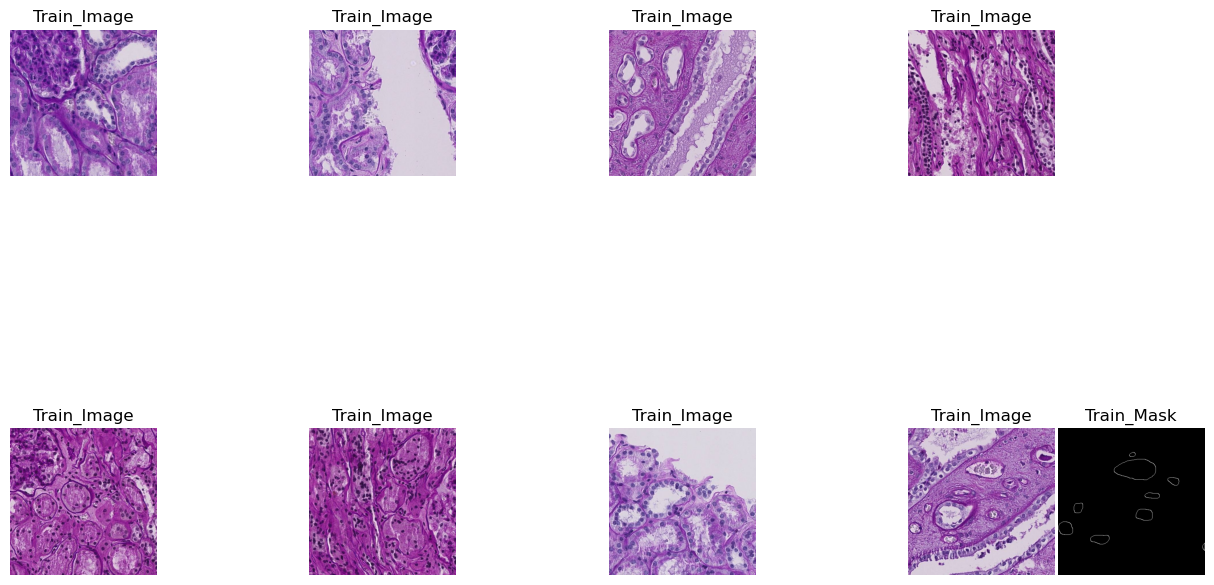

In [12]:
plot_image_mask()

In [13]:
class HuBMAPClassificationNN(torch.nn.Module):
    def __init__(self):
        super(HuBMAPClassificationNN, self).__init__()
        
        self.network_1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.network_2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.network_1(x)
        x = self.network_2(x)
        x = torch.sigmoid(x)
        return x

In [14]:
model = HuBMAPClassificationNN().to(device)
print(model)

HuBMAPClassificationNN(
  (network_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (network_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
  )
)


In [15]:
class Trainer:
    
    def train_dataloader(self,image_folder,labels_file):
        dataset = ImageHuBMAPDataset(image_folder,labels_file)
        return DataLoader(dataset, batch_size=config.batch_size, shuffle=True)
        
  
    def fit(self,epochs, lr, model, train_loader,opt_func):
        history =[]
        result = {}
        
        criterion = torch.nn.BCELoss() 
        optimizer = opt_func(model.parameters(), lr=lr)
        
        for epoch in range(epochs):
            model.train() 
            running_loss = 0.0
            accuracy = 0.0
            start_time = time.time()
            
            for images, masks in train_loader:
                images = images.to(device)
                masks = masks.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                masks = masks.unsqueeze(1) 
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            epoch_loss = running_loss / len(train_loader)
            epoch_time = time.time() - start_time
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Time: {epoch_time:.2f} seconds")
            result['Train_loss'] = epoch_loss
            history.append(result)
        return history 
        
    
trainer = Trainer()

In [16]:
history=trainer.fit(config.n_epochs, config.learning_rate, model, 
                    trainer.train_dataloader(image_folder,labels_file),
                    torch.optim.Adam)

Epoch 1/10, Loss: 0.3125, Time: 71.58 seconds
Epoch 2/10, Loss: 0.0670, Time: 45.75 seconds
Epoch 3/10, Loss: 0.0342, Time: 45.97 seconds
Epoch 4/10, Loss: 0.0325, Time: 46.02 seconds
Epoch 5/10, Loss: 0.0318, Time: 46.01 seconds
Epoch 6/10, Loss: 0.0313, Time: 46.18 seconds
Epoch 7/10, Loss: 0.0310, Time: 46.46 seconds
Epoch 8/10, Loss: 0.0307, Time: 47.37 seconds
Epoch 9/10, Loss: 0.0306, Time: 46.77 seconds
Epoch 10/10, Loss: 0.0303, Time: 47.94 seconds


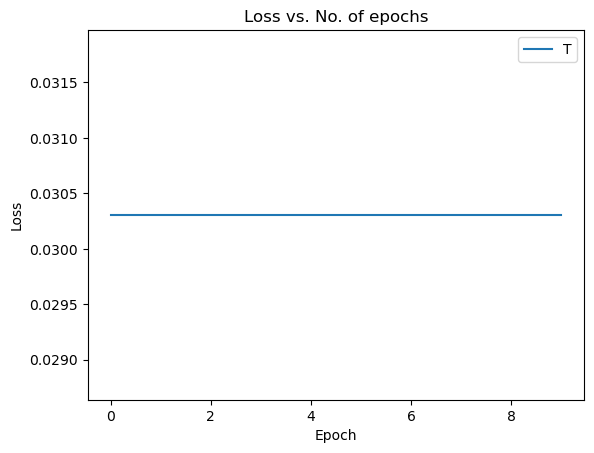

In [17]:
plot_losses(history)

In [33]:
class ImageHuBMAPDatasetTest(Dataset):
    
    def __init__(self, testFiles, testFolder,transforms):
        self.testFiles = testFiles 
        self.testFolder = testFolder 
        self.transforms = transforms 
        
    def __getitem__(self, idx):
        
        testId = self.testFiles[idx]
        inputPath = os.path.join(self.testFolder, testId)
        im  = Image.open(inputPath)
        if self.transforms is not None: 
            transformed = self.transforms(image = np.array(im))
            return testId.split(".")[0], transformed['image']
        
    def __len__(self):
        return len(self.testFiles)

In [42]:
root_path='/kaggle/input/hubmap-hacking-the-human-vasculature'

In [43]:
class Test:
    
    def encode_binary_mask(mask):
        if mask.dtype != bool:
            raise ValueError(
                "encode_binary_mask expects a binary mask, received dtype == %s" %
                mask.dtype)

        mask = np.squeeze(mask)
        if len(mask.shape) != 2:
            raise ValueError(
                "encode_binary_mask expects a 2d mask, received shape == %s" %
                mask.shape)

        mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
        mask_to_encode = mask_to_encode.astype(np.uint8)
        mask_to_encode = np.asfortranarray(mask_to_encode)
        encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]
        binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
        base64_str = base64.b64encode(binary_str)
        return base64_str
    
    
    def encode_output(outputs,idx):
        blood_vessel = torch.argmax(outputs, 1) 
        blood_vessel = blood_vessel == 1
        blood_vessel = blood_vessel * 1
    
        blood_vessel = blood_vessel.cpu().numpy()
        all_encode = {} 
        for i in range(blood_vessel.shape[0]):
            list_encode = []
            sliceImage = blood_vessel[i,:,:]
            binarized = sliceImage > 0
            coded_len = encode_binary_mask(binarized)
            list_encode.append(coded_len)
            all_encode[idx[i]] =list_encode
        return all_encode

    
   
    def get_test_transforms(self):
        return transforms.Compose([transforms.ToTensor(),transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    
    def test_dataloader(self,image_folder):
        dataset = ImageHuBMAPDatasetTest(os.listdir(root_path),
                                            test_image_folder,self.get_test_transforms())
        return DataLoader(dataset, batch_size=config.batch_size)
    
    

    def evaluate(self,model):
        model.eval()
        predictions = []
        outputdict ={}
        outputsoftmax = torch.nn.Softmax2d() 
        with torch.no_grad():
            for idx,images in tqdm(self.test_dataloader(test_image_folder)):
                images = images.to(device)
                outputs = model(images)
                outputs = outputsoftmax(output)
                encoded = encode_output(outputs, idx)
                for key in encoded: 
                    outputdict[key] = " ".join([f"0 1.0 {x.decode('utf-8')}" for x in  encoded[key]])
                print(outputdict)    
        return outputdict
        
    
    
        
test = Test()
test.evaluate(model)

  0%|          | 0/1 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/hubmap-hacking-the-human-vasculature/test/sample_submission.csv'

In [38]:
class Submission:
    
    def submit_results(self,OutputDict):
        submission = pd.DataFrame(OutputDict.items(), columns= ["id", "prediction_string"]) 
        submission["height"] = 512
        submission["width"] = 512 
        submission= submission[["id","height","width","prediction_string"]]
        submission.to_csv("submission.csv", index= False)
        
        
submit = Submission()


  0%|          | 0/1 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/hubmap-hacking-the-human-vasculature/test/sample_submission.csv'